#**딥러닝 학습 및 모델 평가**

학습 목표:
- MLP layer로 이루어진 이미지 분류 모델을 학습한다.
- 딥러닝 모델 학습에 핵심적인 요소들에 대해 알아본다.

**Content**
1. Prerequisite
2. Gradient Descent
3. Optimizer
4. Activation Function
5. Batch Normalization
6. Regularization
7. Hyperparameters


#1. Prerequisite

> 본격적인 실습을 진행하기 앞서 MNIST dataset을 위한 DataLoader와 Trainer class를 생성한다.

##1-1. Check Runtime and Import Packages

>GPU 사용을 위해 런타임의 유형을 변경한다.
>
>상단 메뉴에서 [런타임]->[런타임유형변경]->[하드웨어가속기]->[GPU]
>
>변경 이후 아래의 cell을 실행 시켰을 때, torch.cuda.is_avialable()이 True가 나와야 한다.



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torch.utils import data
print(torch.__version__)
print(torch.cuda.is_available())

random_seed = 1234
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

2.3.0+cu121
True


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
np.random.seed(random_seed)

##1-2. Dataset

>이번 실습에서 사용할 데이터셋은 지난 강의와 마찬가지로 MNIST 데이터셋이다.
>
>지난 강의에서 처럼 MNIST 데이터셋을 직접 다운로드할 수도 있지만, Pytorch 라이브러리는 MNIST를 위한 Dataset class를 제공한다.
>
>직접 Dataset class를 구현하지 않고 torchvision.dataset에서 기본으로 제공하는 MNIST dataset class를 사용함.
>
> 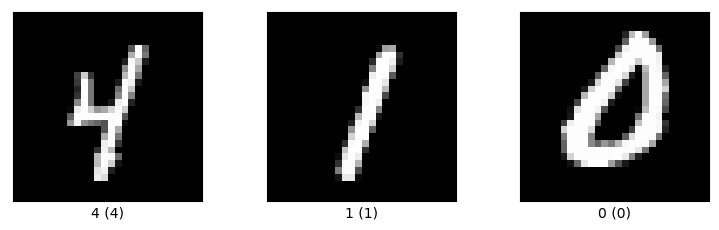
>
>학습에 사용할 데이터셋은 train_dataset, 평가를 위한 데이터셋은 test_dataset이라고 구분지어 선언한다.
>
>MNIST 데이터셋은 train을 위한 사진 6만장, test를 위한 사진 1만장을 제공한다.

In [ ]:
transforms = torchvision.transforms.ToTensor()
train_dataset = torchvision.datasets.MNIST(root="./", train=True, download=True, transform=transforms)
test_dataset = torchvision.datasets.MNIST(root="./", train=False, download=True, transform=transforms)

print(f"Number of train images\t: {len(train_dataset)}")
print(f"Number of test images\t: {len(test_dataset)}")

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 14877021.56it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 499293.91it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4506993.51it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2685442.45it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Number of train images	: 60000
Number of test images	: 10000


In [ ]:
sample_data = train_dataset[0][0]
sample_target = train_dataset[0][1]

In [ ]:
sample_target

5

In [ ]:
sample_data.shape

torch.Size([1, 28, 28])

##1-3. Dataloader

>데이터셋을 불러오는 모듈인 Dataloader을 선언한다.
>
>지난 실습에서 학습했듯이 train_dataset을 위한 dataloader는 shuffle=True라는 옵션을 주고, test_dataset을 위한 dataloader은 shuffle=False로 한다.
Shuffle이라는 옵션을 사용하면, 데이터셋을 랜덤한 순서로 불러오게 된다.
>
>한 번에 몇장의 사진을 불러올지를 batch_size라는 옵션으로 정할 수 있다.
이번 실습에서는 batch_size를 64로 고정하도록 한다.
>전체 데이터의 개수가 batch_size로 나눠지지 않을 수도 있다.
>이런 경우에 마지막 batch는 버림을 하는 옵션을 추가한다. (drop_last=True)

In [ ]:
len(test_dataset)

10000

In [ ]:
batch_size = 64

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

print(f"Number of steps per batch: {len(train_dataloader)}")

Number of steps per batch: 937


In [ ]:
60000/64

937.5

##1-4. 2-layer MLP 모델

>학습에 사용할 기본 모델을 선언하도록 한다.
>
>가장 기본이 되는 모델로 지난 강의에서 예시로 본 2-layer MLP 모델을 사용한다.
>모델은 nn.Module class를 상속하는데, 이는 가장 기본이 되는 딥러닝 모델이다.
>nn.Module을 상속 받은 모델 안에 layer들과 forward 함수를 정의하면 우리만의 딥러닝 모델을 구현할 수 있다.
>
>input_dim은 입력으로 들어오는 사진의 차원을 뜻하며, MNIST 사진들은 28 × 28로 총 784개의 숫자로 이루어진 데이터이므로, input_dim=784로 설정한다.
>
>output_dim은 출력 할 숫자의 개수이며, 우리는 각 숫자를 특정 숫자일 확률로 해석할 것이기 때문에, output_dim은 한 자리 숫자의 개수인 10으로 설정한다. (0~9)

In [ ]:
class MyModel(nn.Module):
    def __init__(self,
                 input_dim=784,
                 hidden_dim=32,
                 output_dim=10):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.activation1 = nn.Sigmoid()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation1(x)
        x = self.fc2(x)
        return x

>모델을 생성하고, GPU 메모리에 복사한다.

In [ ]:
model = MyModel()
model.to('cuda') # GPU 사용을 위한 코드

MyModel(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (activation1): Sigmoid()
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)

>`print` 함수를 통해 생성된 모델의 구조를 확인해보자.

In [ ]:
print(model)

MyModel(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (activation1): Sigmoid()
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)


>또 `model.named_parameters()`를 통해 모델을 구성하는 parameter와 그 이름을 확인해보자.

In [ ]:
for name, param in model.named_parameters():
    print(f'[{name}]')
    print(param)

[fc1.weight]
Parameter containing:
tensor([[-0.0336, -0.0070, -0.0172,  ...,  0.0146,  0.0184, -0.0230],
        [-0.0269, -0.0255,  0.0351,  ..., -0.0100,  0.0254,  0.0084],
        [ 0.0227, -0.0012,  0.0045,  ...,  0.0198, -0.0041,  0.0011],
        ...,
        [ 0.0003,  0.0054,  0.0299,  ..., -0.0030,  0.0311, -0.0167],
        [ 0.0155,  0.0045, -0.0006,  ...,  0.0163, -0.0161,  0.0110],
        [ 0.0353, -0.0108,  0.0022,  ...,  0.0272,  0.0337,  0.0346]],
       device='cuda:0', requires_grad=True)
[fc1.bias]
Parameter containing:
tensor([ 1.5584e-02,  3.4048e-03, -3.1744e-05, -2.0563e-03, -3.0478e-02,
        -2.7517e-02,  3.1779e-02,  2.5705e-02,  1.4222e-02, -2.4536e-02,
         3.9567e-03, -3.4369e-02, -1.8231e-02, -1.3924e-02,  3.2030e-02,
        -3.1832e-02,  2.8760e-02, -1.0132e-02, -3.4506e-03,  3.2684e-02,
         3.2235e-02,  2.3060e-02,  3.1458e-03, -2.0360e-02, -2.3396e-02,
        -3.3111e-02, -6.5612e-03, -2.9647e-02,  5.7365e-03, -3.5042e-02,
         1.6732e

#2. Gradient Descent

>모델과 데이터가 있으니, 이제 gradient descent를 통해서 모델을 학습시킬 수 있다.
>
>Gradient를 계산하고 모델을 업데이트 해주는 모듈을 optimizer이라고 한다.
>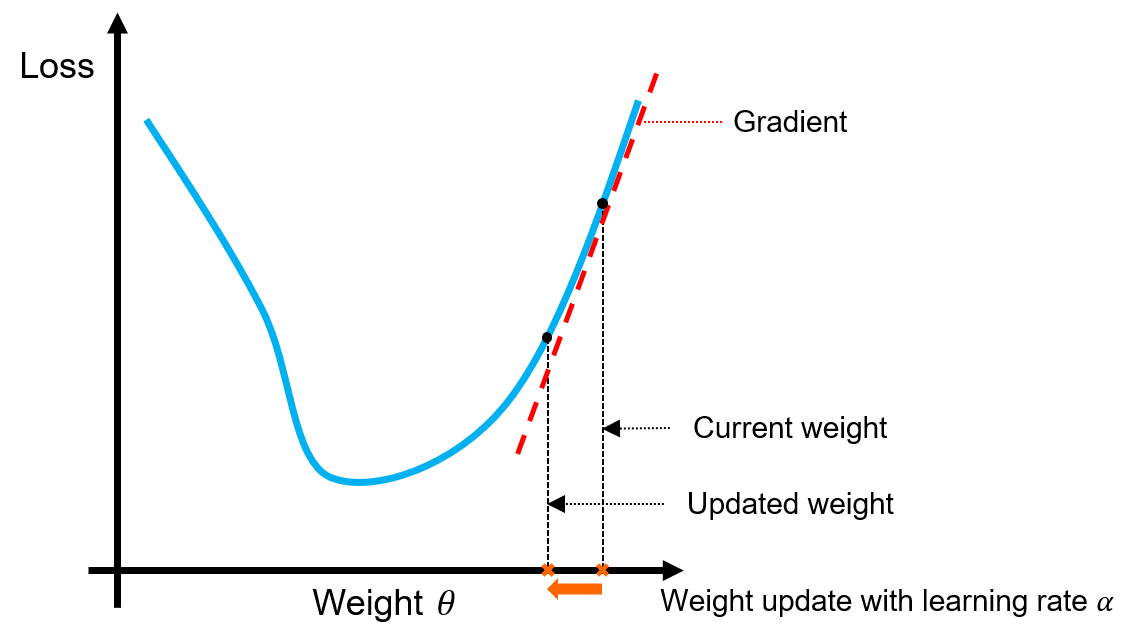
>
>Stochastic Gradient Descent를 위해서 optimizer을 선언한다.
>
>Optimizer은 gradient를 구할 대상인 모델 파라메터와 learning rate를 주어 선언할 수 있다. Learning rate은 우선 0.01로 설정한다.
>
>Gradient를 구하기 위해서는 loss function이라고 불리는 목적함수가 필요한데, classification에서는 cross-entropy loss를 사용한다.

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

>이제 forward, backward pass를 실행하고, 해당 optimizer를 이용해서 모델을 학습해보자.
>
>가장 먼저 train_dataloader에서 한 개의 데이터 batch를 로드한다.

In [ ]:
train_dataloader

In [ ]:
batch = next(iter(train_dataloader))
inputs, labels = batch

print(inputs.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


>Train과 evaluation 단계에 각각 다르게 작동하는 layer들이 존재하기 때문에 모델의 "mode"를 설정해주어야 한다.
>
>예를 들어, Batch Normalization Layer와 같은 normalization layer들은 학습(train) 과정에서는 입력 batch의 통계값 (per-batch statistics) 를 사용하고, 추론(evaluation) 단계에서는 학습과정에서 저장된 통계값 (running statistics) 을 사용해 정규화 한다.
>

`model.train()`
- model을 train mode로 설정한다.

`model.eval()`
- model을 evaluation mode로 설정한다.


In [ ]:
model.train() # model을 train mode로 설정

MyModel(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (activation1): Sigmoid()
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)

>MLP layer는 (batch_size, in_features) 크기의 입력을 받는다.
>
>따라서 `inputs` 을 이에 맞게 reshape 해줘야 한다.

In [ ]:
inputs = inputs.reshape(batch_size, -1)# batch size x 1 x 28 x 28 => batch size x ??? => batch size x 784
print('inputs shape: ', inputs.shape)

inputs shape:  torch.Size([64, 784])


>Forward pass를 실행한다.
>
>모든 연산은 같은 device에서 이루어져야 하기 때문에, `inputs` 텐서와 `labels` 텐서를 GPU 메모리에 로드한다.

In [ ]:
inputs = inputs.to('cuda')
labels = labels.to('cuda')

outputs = model(inputs) # forward pass

In [ ]:
outputs.shape

torch.Size([64, 10])

>Forward pass의 결과로 (batch_size, 10) 크기의 outputs tensor가 반환된다.

In [ ]:
print('outputs[0]: ', outputs[0])
print('outputs shape: ', outputs.shape)

outputs[0]:  tensor([-0.1670, -0.5003, -0.2504,  0.3480, -0.2771, -0.4258, -0.1707, -0.1723,
         0.6884,  0.0124], device='cuda:0', grad_fn=<SelectBackward0>)
outputs shape:  torch.Size([64, 10])


>Cross-entropy loss를 계산한다.

In [ ]:
loss = criterion(outputs, labels)

print('loss: ', loss)

loss:  tensor(2.3421, device='cuda:0', grad_fn=<NllLossBackward0>)


>`parameter.grad`를 통해 model parameter의 gradient 값을 확인할 수 있다.
>
>예시로 fc2 layer (두번째 linear layer) 의 gradient를 확인해보자.

In [ ]:
params = list(model.named_parameters())

name, param = params[2]

print(name)
print(f'grad: {param.grad}')

fc2.weight
grad: None


>아직 backpropagation을 하지 않았기 때문에 None 값인 것을 확인할 수 있다.
>
>이제 `loss.backward()`를 실행시켜보자.

In [ ]:
loss.backward() # backward pass

>다시 fc2 layer의 gradient를 확인해보자.
>
>Backpropagation으로 gradient가 계산된 것을 확인할 수 있다.

In [ ]:
params = list(model.named_parameters())

name, param = params[2]

print(name)
print(f'grad: {param.grad}')

fc2.weight
grad: tensor([[-2.3356e-03, -1.6932e-04, -7.6012e-03, -3.2243e-03, -1.9654e-03,
         -2.9438e-03, -4.5686e-03, -3.9268e-03, -2.3914e-03,  1.7698e-03,
         -3.4082e-03, -3.1358e-03, -5.2547e-03, -4.1389e-03, -5.4433e-03,
          1.2776e-03, -5.5124e-03, -4.3994e-03, -1.3358e-04, -1.5377e-03,
         -4.0911e-03, -1.2963e-03, -2.7569e-03, -2.9416e-03, -4.4934e-03,
         -4.5836e-03, -3.5650e-03, -5.2268e-03, -4.3134e-03, -1.7959e-03,
         -4.6807e-03, -3.1759e-03],
        [-8.4291e-03, -6.9155e-03, -5.7268e-03, -6.4791e-03, -1.0618e-02,
         -6.8399e-03, -7.0277e-03, -9.0965e-03, -5.1379e-03, -8.0251e-03,
         -6.0176e-03, -7.0881e-03, -5.5278e-03, -6.7137e-03, -5.6926e-03,
         -1.1643e-02, -6.9023e-03, -7.0065e-03, -6.9762e-03, -9.0642e-03,
         -7.0371e-03, -7.9300e-03, -6.9973e-03, -9.1004e-03, -4.5246e-03,
         -6.2995e-03, -8.4279e-03, -7.4893e-03, -7.3361e-03, -6.2682e-03,
         -4.3961e-03, -7.8632e-03],
        [-1.4037e-02, -

>`optimizer.step()`을 통해 stochastic gradient descent를 할 수 있다.
>
>model의 parameter가 잘 업데이트 되는지 확인해보자.

In [ ]:
print(f'param before update: {param[0][0]}')
print(f'grad of param: {param.grad[0][0]}')

optimizer.step() # update

print(f'param after update: {param[0][0]}')

param before update: 0.08994942158460617
grad of param: -0.002335566096007824
param after update: 0.08997277915477753


>gradient에 learning rate(0.01)을 곱한 값 만큼 업데이트가 된 것을 확인할 수 있다.
>
>이렇게 model 학습을 1 step 진행했다.
>
>다만 한 가지 주의해야할 점은, PyTorch 실습 단원에서 확인한 것과 같이 grdient는 계속해서 누적 된다.
>
>Forward 와 backward를 여러번 반복하면 gradient가 계속해서 누적되는 것을 확인할 수 있다.

In [ ]:
# forward, backward pass 5번 반복
for i in range(5):
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()

    print(f'{i} grad of param: {param.grad[0][0]}')

0 grad of param: -0.004600421525537968
1 grad of param: -0.006865276955068111
2 grad of param: -0.009130132384598255
3 grad of param: -0.011394987814128399
4 grad of param: -0.013659843243658543


>이를 해결하기 위해서 `optimizer.zero_grad()`를 사용해 매 step 마다 gradient를 0으로 초기화 해줘야 한다.

In [ ]:
for i in range(3):
    optimizer.zero_grad() # gradient 초기화
    print(f'{i} initial grad: {param.grad}') # 0
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()

    print(f'{i} grad after backprop: {param.grad[0][0]}')

0 initial grad: None
0 grad after backprop: -0.0022648554295301437
1 initial grad: None
1 grad after backprop: -0.0022648554295301437
2 initial grad: None
2 grad after backprop: -0.0022648554295301437


>이를 기반으로 모델을 10 epoch 학습해보자.
>
>전체 학습 코드는 다음과 같다.

Epoch:  1| Step   500	| Loss: 2.263
Epoch:  2| Step  1000	| Loss: 2.072
Epoch:  2| Step  1500	| Loss: 1.919
Epoch:  3| Step  2000	| Loss: 1.529
Epoch:  3| Step  2500	| Loss: 1.398
Epoch:  4| Step  3000	| Loss: 1.113
Epoch:  4| Step  3500	| Loss: 1.042
Epoch:  5| Step  4000	| Loss: 0.880
Epoch:  5| Step  4500	| Loss: 0.839
Epoch:  6| Step  5000	| Loss: 0.743
Epoch:  6| Step  5500	| Loss: 0.717
Epoch:  7| Step  6000	| Loss: 0.651
Epoch:  7| Step  6500	| Loss: 0.630
Epoch:  8| Step  7000	| Loss: 0.585
Epoch:  9| Step  7500	| Loss: 0.624
Epoch:  9| Step  8000	| Loss: 0.540
Epoch: 10| Step  8500	| Loss: 0.527
Epoch: 10| Step  9000	| Loss: 0.500


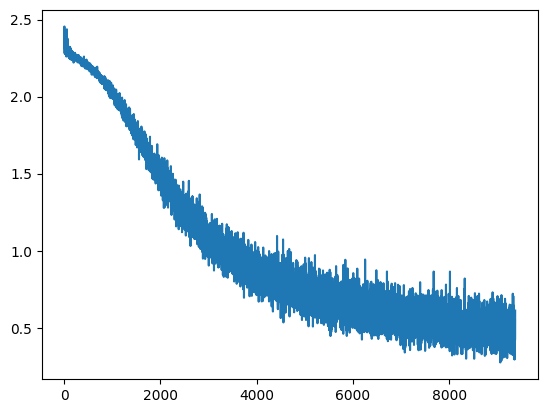

In [ ]:
# 전체 학습 코드
model = MyModel() # 모델 선언
model.to('cuda') # GPU 사용을 위한 코드
optimizer = optim.SGD(model.parameters(), lr=0.01) # SGD optimizer 선언
criterion = nn.CrossEntropyLoss()

epoch = 10 # 데이터셋을 10번 반복해서 학습할 것
step = 0 # Gradient update 횟수를 세기 위한 변수
steps = []
loss_list = []
model.train()
for e in range(epoch):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader):
        inputs, labels = data
        inputs = inputs.reshape(inputs.shape[0], -1) # 28x28 이미지를 일렬로 펴 768x1 벡터로 변환
        inputs = inputs.to('cuda') # GPU 사용을 위한 코드
        labels = labels.to('cuda') # GPU 사용을 위한 코드

        # Gradient descent 방법
        optimizer.zero_grad()               # gradient 초기화
        outputs = model(inputs)             # forward pass
        loss = criterion(outputs, labels)   # loss function
        loss.backward()                     # backward pass
        optimizer.step()                    # update

        running_loss += loss.item()

        step += 1
        steps.append(step)
        loss_list.append(loss.item())

        if step % 500 == 0 and i != 0:   # loss 출력
            print(f'Epoch: {e+1:2d}| Step {step:5d}\t| Loss: {running_loss/(i):.3f}')

    running_loss = 0.0

plt.plot(steps, loss_list)

>loss가 줄어들며 학습이 되는 것을 확인할 수 있다.
>
>다음으로, inference를 통해 test batch의 정답을 예측해보자.

In [ ]:
model.eval() # evaluation mode

batch = next(iter(test_dataloader))
inputs, labels = batch

inputs = inputs.to('cuda')
labels = labels.to('cuda')
inputs = inputs.reshape(-1, 784)
output = model(inputs)

print(output)

tensor([[ 0.3796, -1.9552, -0.4590,  ...,  6.0048, -0.4793,  2.3110],
        [ 1.5500, -0.1476,  3.5444,  ..., -3.7643,  0.8450, -3.5794],
        [-3.2919,  4.4731,  0.9131,  ..., -0.0416,  0.4284, -0.4567],
        ...,
        [-4.3787, -1.3835, -1.8191,  ...,  0.5040,  1.4781,  3.4831],
        [-0.1295, -0.3145, -1.0675,  ..., -1.4151,  2.3113, -0.8295],
        [ 1.2412, -1.9748,  2.2645,  ..., -3.3998, -0.6189, -1.4565]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


>output score가 가장 큰 class를 모델의 예측 결과로 사용한다.

In [ ]:
values, pred = output.max(1, keepdim=False)
print(f'max scores: {values}')
print(f'indices of max scores: {pred}')

max scores: tensor([6.0048, 3.5444, 4.4731,  ..., 4.3417, 2.8076, 6.3092], device='cuda:0',
       grad_fn=<MaxBackward0>)
indices of max scores: tensor([7, 2, 1,  ..., 4, 5, 6], device='cuda:0')


>반환된 indices(pred) 와 데이터의 labels가 일치하는지 확인해보자.

In [ ]:
np.where(pred.cpu() != labels.cpu())

(array([   8,   33,   46, ..., 9980, 9982, 9992]),)

gt labels:  tensor(1, device='cuda:0')
pred:  tensor(3, device='cuda:0')
tensor(False, device='cuda:0')


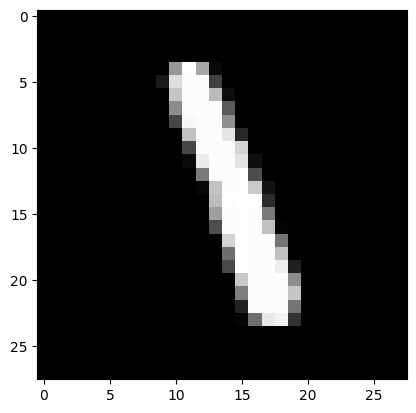

In [ ]:
print('gt labels: ', labels[46])
print('pred: ', pred[46])

print(torch.eq(pred[46], labels[46])) # pred == labels 인지 확인

to_pil = torchvision.transforms.ToPILImage()
plt.imshow(np.array(to_pil(inputs[46].reshape(1,28,28).to('cpu'))), cmap='gray')

>예측값과 라벨을 비교해 예시 데이터 입력에 대해 모델이 정답을 출력한 것을 확인했다
>
>다음 코드를 통해 맞힌 정답의 개수를 계산할 수 있다.

In [ ]:
correct = torch.eq(pred, labels).sum().item()

print('number of correct answers: ', correct)

number of correct answers:  8873


>이제 전체 test data에 대해 정답을 계산해보고, 정확도 (test accuracy)를 측정해보자.

In [ ]:
model.eval()
correct = 0
for inputs, labels in test_dataloader:
    inputs = inputs.reshape(-1, 784)
    inputs = inputs.to('cuda')
    labels = labels.to('cuda')

    output = model(inputs)

    pred = output.max(1, keepdim=False)[1] # 가장 큰 숫자의 번호를 정답으로 예측
    correct += torch.eq(pred, labels).sum().item() # 예측한 정답과 실제 정답이 맞는 경우 correct

test_acc = correct / len(test_dataloader.dataset)
print('Test accuracy: %.3f' %(test_acc))

Test accuracy: 0.887


>모델 학습과 평가 코드는 반복적으로 사용되기 때문에 함수화 해두면 편리하게 사용할 수 있다.


In [ ]:
########################################## TEMPLETE ###############################################
def train_model(model, criterion, optimizer, epoch):
    step = 0
    steps = []
    loss_list = []
    model.train()
    for e in range(epoch):
        running_loss = 0.0
        for i, data in enumerate(train_dataloader):
            inputs, labels = data
            inputs = inputs.reshape(inputs.shape[0], -1)
            inputs = inputs.to('cuda')
            labels = labels.to('cuda')

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            step += 1
            steps.append(step)
            loss_list.append(loss.item())

            if step % 500 == 0 and i != 0:
                print(f'Epoch: {e+1:2d}| Step {step:5d}\t| Loss: {running_loss/(i):.3f}')


        running_loss = 0.0

    plt.plot(steps, loss_list)
    return model

def test_model(model):
    model.eval()
    correct = 0
    for inputs, labels in test_dataloader:
        inputs = inputs.reshape(-1, 784)
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')

        output = model(inputs)

        pred = output.max(1, keepdim=False)[1]
        correct += torch.eq(pred, labels).sum().item()

    test_acc = correct / len(test_dataloader.dataset)
    print('test_acc: %.3f' %(test_acc))

#3. Optimizer

>앞서 gradient descent를 할 때 사용한 optimizer은 stochastic gradient descent (SGD)이다.
>
>Optimizer의 종류에 따라 모델이 학습되는 양상이 다른데, 다른 optimizer을 사용하는 방법에 대해서 알아볼 것이다.
>
>이번 실습에서는 가장 널리 사용되는 optimizer 중 하나인 Adam optimizer을 사용할 것이다.
>
>[링크](https://pytorch.org/docs/stable/optim.html)에 있는 다른 optimzer도 자유롭게 적용해볼 수 있다.

##3-1. Adam

>Adam optimizer은 Adaptive momentum의 줄임말로, momentum이 도입된 optimizer이다.
>
>특정 update를 위해 그 당시 gradient인 $∇_ΘJ(Θ)$를 사용하는 것이 아니라, 이전 gradient의 합 또는 가중 평균을 사용한다.
>
>수식으로 확인하면 다음과 같다.
>
>$m_t = \beta_1 m_{t-1} + (1-\beta_1)∇_ΘJ(Θ)$
>
>$v_t = \beta_2 v_{t-1} + (1-\beta_2)(∇_ΘJ(Θ))^2$
>
>$m_t$는 gradient의 moving average이고 $v_t$는 gradient 크기의 moving average이다.
>
>$v_t$가 누적 합에서 moving average로 바뀌었는데, learning rate이 극도로 작아지는 것을 방지하기 위함이다.
>
>이것으로 parameter update를 다음과 같이 진행한다.
>
>$Θ_{t+1} = \Theta_{t} - \frac{\eta}{v_t + \epsilon} m_t$
>
>여기서 $\eta$는 learning rate에 해당한다.
>
>Momentum은 SGD와 비교하여 gradient가 0인 지점(saddle point)에서 수렴하지 않고 지속적인 학습을 가능하게 한다.

Epoch:  1| Step   500	| Loss: 0.533
Epoch:  2| Step  1000	| Loss: 0.220
Epoch:  2| Step  1500	| Loss: 0.193
Epoch:  3| Step  2000	| Loss: 0.149
Epoch:  3| Step  2500	| Loss: 0.153
Epoch:  4| Step  3000	| Loss: 0.129
Epoch:  4| Step  3500	| Loss: 0.128
Epoch:  5| Step  4000	| Loss: 0.111
Epoch:  5| Step  4500	| Loss: 0.111
Epoch:  6| Step  5000	| Loss: 0.098
Epoch:  6| Step  5500	| Loss: 0.100
Epoch:  7| Step  6000	| Loss: 0.083
Epoch:  7| Step  6500	| Loss: 0.091
Epoch:  8| Step  7000	| Loss: 0.082
Epoch:  9| Step  7500	| Loss: 0.099
Epoch:  9| Step  8000	| Loss: 0.076
Epoch: 10| Step  8500	| Loss: 0.063
Epoch: 10| Step  9000	| Loss: 0.070


MyModel(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (activation1): Sigmoid()
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)

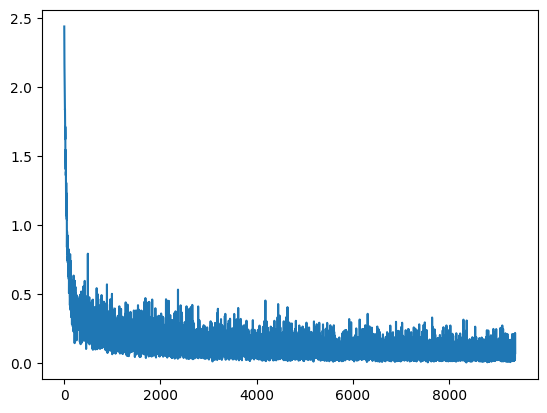

In [ ]:
model = MyModel()
model.to('cuda')

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005, betas=(0.9, 0.999)) # Adam 사용, beta1, beta2 설정

epoch = 10

train_model(model, criterion, optimizer, epoch)

>Training loss값을 앞의 SGD optimizer와 비교해보면, Adam optimizer를 사용할 경우 훨씬 학습이 빠르게 잘 되는 것을 확인할 수 있다.

In [ ]:
test_model(model)

test_acc: 0.960


>더불어 test accuracy 또한 훨씬 높은 값이 나온다.

#4. Activation Functions

>Linear layer는 행렬곱이기 때문에 non-linearity 없이 행렬만 연속해서 곱하게 된다면 그것은 하나의 행렬곱과 다를 것이 없다.
>
>그렇기 때문에 linear layer 사이에 non-linear한 성질을 갖는 activation function을 사용하는 것은 필수적이다.
>
>Activation function의 예시로는 다음 네개의 함수가 있다.
>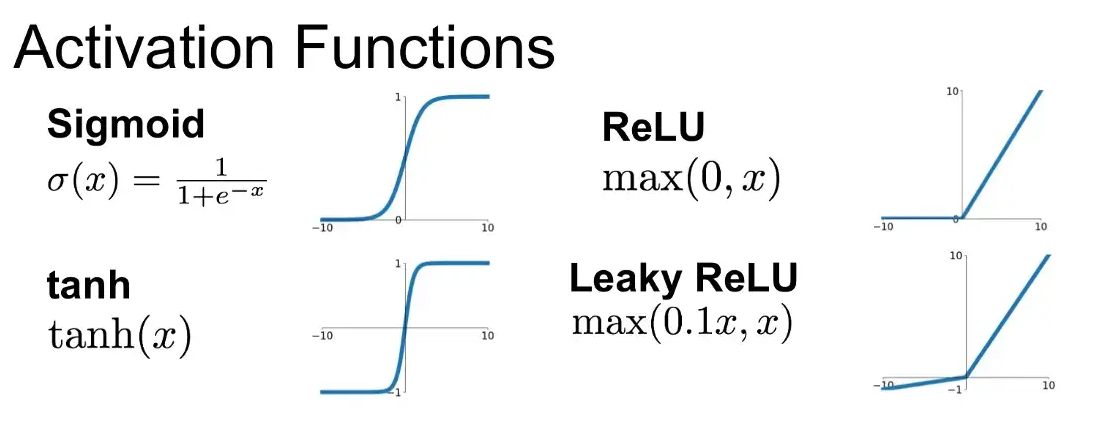
>
>지금까지 우리는 sigmoid함수를 사용하고 있었는데, sigmoid 함수는 1) 중심이 0이 아니라는 점과 2) 미분값이 0에 가까운 구간이 많다는 단점이 있다.
>
>그래서 이번 실습에서는 tanh, ReLU, 그리고 LeakyReLU를 다루어보겠다.
>
>먼저 이번 단원에서 사용할 모델인 3-layer MLP 모델을 선언한다.

In [ ]:
class MyModel(nn.Module):
    def __init__(self,
                 input_dim=784,
                 hidden_dim=(32, 32),
                 output_dim=10):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim[0])
        self.activation1 = nn.ReLU() # Sigmoid activation 사용
        self.fc2 = nn.Linear(hidden_dim[0], hidden_dim[1])
        self.activation2 = nn.ReLU() # Sigmoid activation 사용
        self.fc3 = nn.Linear(hidden_dim[1], output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation1(x)
        x = self.fc2(x)
        x = self.activation2(x)
        x = self.fc3(x)
        return x

>학습과 테스트를 진행한다.

Epoch:  1| Step   500	| Loss: 2.160
Epoch:  2| Step  1000	| Loss: 0.902
Epoch:  2| Step  1500	| Loss: 0.689
Epoch:  3| Step  2000	| Loss: 0.461
Epoch:  3| Step  2500	| Loss: 0.439
Epoch:  4| Step  3000	| Loss: 0.400
Epoch:  4| Step  3500	| Loss: 0.377
Epoch:  5| Step  4000	| Loss: 0.342
Epoch:  5| Step  4500	| Loss: 0.343
Epoch:  6| Step  5000	| Loss: 0.325
Epoch:  6| Step  5500	| Loss: 0.318
Epoch:  7| Step  6000	| Loss: 0.308
Epoch:  7| Step  6500	| Loss: 0.301
Epoch:  8| Step  7000	| Loss: 0.288
Epoch:  9| Step  7500	| Loss: 0.405
Epoch:  9| Step  8000	| Loss: 0.276
Epoch: 10| Step  8500	| Loss: 0.277
Epoch: 10| Step  9000	| Loss: 0.262
test_acc: 0.929


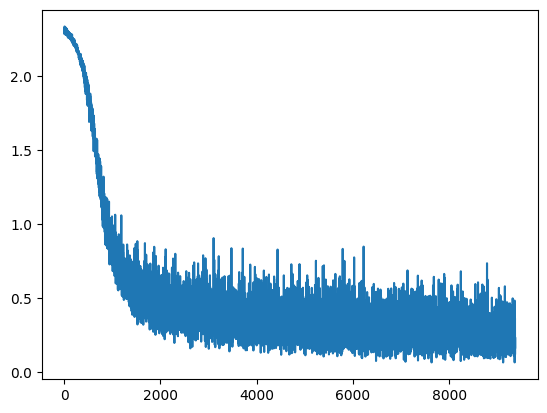

In [ ]:
model = MyModel()
model.to('cuda')

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

model = train_model(model, criterion, optimizer, epoch=10)

test_model(model)

##4-1. tanh

>Activation function을 바꾸기 위해서는 모델을 다시 선언해야한다.
>
>모델의 activation 함수를 다음과 같이 Tanh()로 바꿔보도록 한다.
>
>또, 이제부터는 2-layer MLP 모델이 아닌, 3-layer MLP 모델을 사용해보도록 한다.
>
>Tanh는 sigmoid함수와 유사하지만 함수 출력값의 평균이 0이라는 장점을 갖고 있다.
>
>Activation function의 출력값의 평균이 0이라는 뜻은, 입력 값이 양수로 편향되는 것을 방지할 수 있다는 뜻이고, 안정적인 학습을 가능케한다.
>
>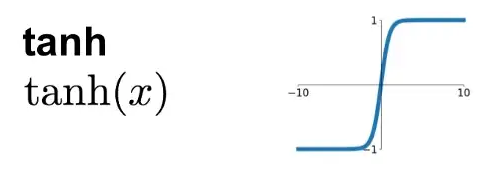

In [ ]:
class MyModel(nn.Module):
    def __init__(self,
                 input_dim=784,
                 hidden_dim=(32, 32),
                 output_dim=10):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim[0])
        self.activation1 = nn.Tanh() # Activation이 바뀜
        self.fc2 = nn.Linear(hidden_dim[0], hidden_dim[1])
        self.activation2 = nn.Tanh() # Activation이 바뀜
        self.fc3 = nn.Linear(hidden_dim[1], output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation1(x)
        x = self.fc2(x)
        x = self.activation2(x)
        x = self.fc3(x)
        return x

Epoch:  1| Step   500	| Loss: 1.957
Epoch:  2| Step  1000	| Loss: 0.903
Epoch:  2| Step  1500	| Loss: 0.753
Epoch:  3| Step  2000	| Loss: 0.532
Epoch:  3| Step  2500	| Loss: 0.492
Epoch:  4| Step  3000	| Loss: 0.421
Epoch:  4| Step  3500	| Loss: 0.396
Epoch:  5| Step  4000	| Loss: 0.365
Epoch:  5| Step  4500	| Loss: 0.349
Epoch:  6| Step  5000	| Loss: 0.330
Epoch:  6| Step  5500	| Loss: 0.320
Epoch:  7| Step  6000	| Loss: 0.297
Epoch:  7| Step  6500	| Loss: 0.297
Epoch:  8| Step  7000	| Loss: 0.281
Epoch:  9| Step  7500	| Loss: 0.300
Epoch:  9| Step  8000	| Loss: 0.262
Epoch: 10| Step  8500	| Loss: 0.273
Epoch: 10| Step  9000	| Loss: 0.251
test_acc: 0.931


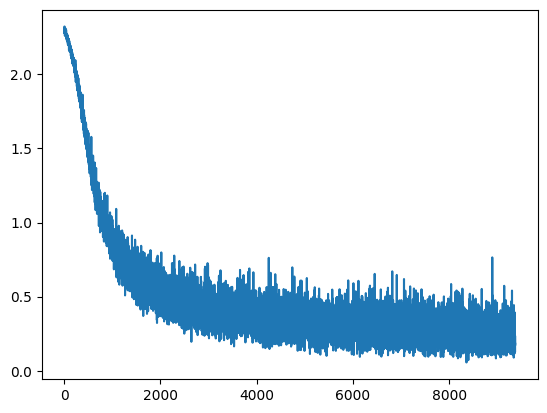

In [ ]:
model = MyModel()
model.to('cuda')

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

model = train_model(model, criterion, optimizer, epoch=10)

test_model(model)

##4-2. ReLU

>Sigmoid나 tanh함수는 y=0, y=1 근처에서 기울기가 0에 가까워 학습이 느려진다는 단점이 있다.
>
>이를 해결하고자 하는 activation function이 바로 ReLU 함수다.
> ReLU는 x값이 음수면 0, 양수면 기울기 1인 그래프를 따르는 함수다.
>
>ReLU는 기울기가 양수일 때 1로 일정하며 줄어들지 않기 때문에 학습이 느려지지 않는다.
>
>특히 큰 모델을 학습 시킬 때, 효과적이고 현재 가장 널리 사용되는 activation function 중 하나다.
>
>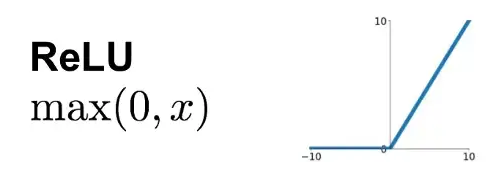

In [ ]:
class MyModel(nn.Module):
    def __init__(self,
                 input_dim=784,
                 hidden_dim=(32, 32),
                 output_dim=10):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim[0])
        self.activation1 = nn.ReLU() # Activation이 바뀜
        self.fc2 = nn.Linear(hidden_dim[0], hidden_dim[1])
        self.activation2 = nn.ReLU() # Activation이 바뀜
        self.fc3 = nn.Linear(hidden_dim[1], output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation1(x)
        x = self.fc2(x)
        x = self.activation2(x)
        x = self.fc3(x)
        return x

Epoch:  1| Step   500	| Loss: 2.120
Epoch:  2| Step  1000	| Loss: 0.807
Epoch:  2| Step  1500	| Loss: 0.672
Epoch:  3| Step  2000	| Loss: 0.465
Epoch:  3| Step  2500	| Loss: 0.429
Epoch:  4| Step  3000	| Loss: 0.369
Epoch:  4| Step  3500	| Loss: 0.357
Epoch:  5| Step  4000	| Loss: 0.315
Epoch:  5| Step  4500	| Loss: 0.326
Epoch:  6| Step  5000	| Loss: 0.308
Epoch:  6| Step  5500	| Loss: 0.307
Epoch:  7| Step  6000	| Loss: 0.290
Epoch:  7| Step  6500	| Loss: 0.291
Epoch:  8| Step  7000	| Loss: 0.282
Epoch:  9| Step  7500	| Loss: 0.361
Epoch:  9| Step  8000	| Loss: 0.267
Epoch: 10| Step  8500	| Loss: 0.288
Epoch: 10| Step  9000	| Loss: 0.254
test_acc: 0.929


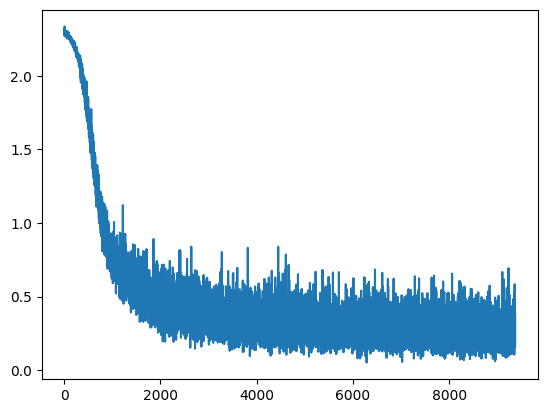

In [ ]:
model = MyModel()
model.to('cuda')

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

model = train_model(model, criterion, optimizer, epoch=10)

test_model(model)

##4-3. LeakyReLU

>ReLU는 음수인 구역에서 gradient가 0이다. 이는 "dead ReLU"라고 하는 현상을 초래할 수 있는데, 모든 activation function의 출력값이 0이 되면 더 이상 업데이트가 되지 않는 현상이다.
>
>LeakyReLU는 입력이 음수인 구간에서도 작은 음수 값을 갖도록 하여 기울기가 0이 되지 않도록 한다.
>
>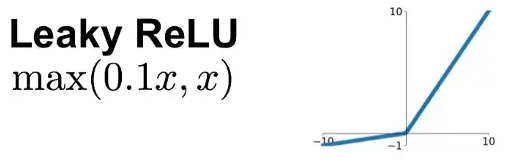

In [ ]:
class MyModel(nn.Module):
    def __init__(self,
                 input_dim=784,
                 hidden_dim=(32, 32),
                 output_dim=10):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim[0])
        self.activation1 = nn.LeakyReLU() # Activation이 바뀜
        self.fc2 = nn.Linear(hidden_dim[0], hidden_dim[1])
        self.activation2 = nn.LeakyReLU() # Activation이 바뀜
        self.fc3 = nn.Linear(hidden_dim[1], output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation1(x)
        x = self.fc2(x)
        x = self.activation2(x)
        x = self.fc3(x)
        return x

Epoch:  1| Step   500	| Loss: 2.130
Epoch:  2| Step  1000	| Loss: 0.865
Epoch:  2| Step  1500	| Loss: 0.676
Epoch:  3| Step  2000	| Loss: 0.447
Epoch:  3| Step  2500	| Loss: 0.434
Epoch:  4| Step  3000	| Loss: 0.372
Epoch:  4| Step  3500	| Loss: 0.366
Epoch:  5| Step  4000	| Loss: 0.341
Epoch:  5| Step  4500	| Loss: 0.335
Epoch:  6| Step  5000	| Loss: 0.318
Epoch:  6| Step  5500	| Loss: 0.315
Epoch:  7| Step  6000	| Loss: 0.298
Epoch:  7| Step  6500	| Loss: 0.297
Epoch:  8| Step  7000	| Loss: 0.288
Epoch:  9| Step  7500	| Loss: 0.364
Epoch:  9| Step  8000	| Loss: 0.271
Epoch: 10| Step  8500	| Loss: 0.257
Epoch: 10| Step  9000	| Loss: 0.261
test_acc: 0.928


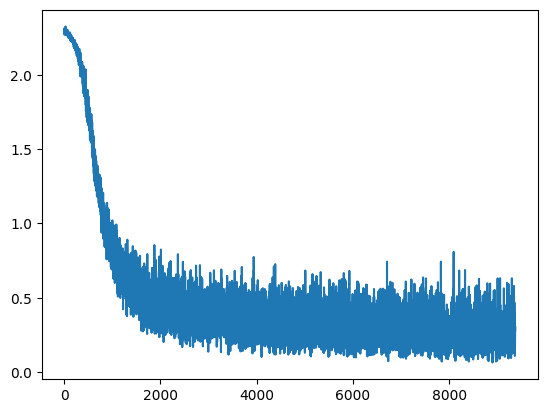

In [ ]:
model = MyModel()
model.to('cuda')

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

model = train_model(model, criterion, optimizer, epoch=10)

test_model(model)

#5. Batch Normalization

>Batch Normalization이란 layer을 통과한 값들의 분포가 한 쪽으로 치우치는 현상을 막기 위해 제안된 방법이다.
>
>매 layer마다 특정한 정규화 과정을 거치게 되는데, 한 mini-batch안의 평균과 분산을 각각 0과 1로 변환 한 후, 특정한 값 $\gamma$를 곱한 후 또 $\beta$를 더해준다.
>
>$y = \frac{x - \mathbb{E}(x)}{\sqrt{Var(x) + \epsilon}} \times \gamma + \beta$
>
>이렇게 되면 다음 layer은 항상 정규화된 분포를 입력으로 받게 되어 학습 안정성이 증가하게 된다.
>
>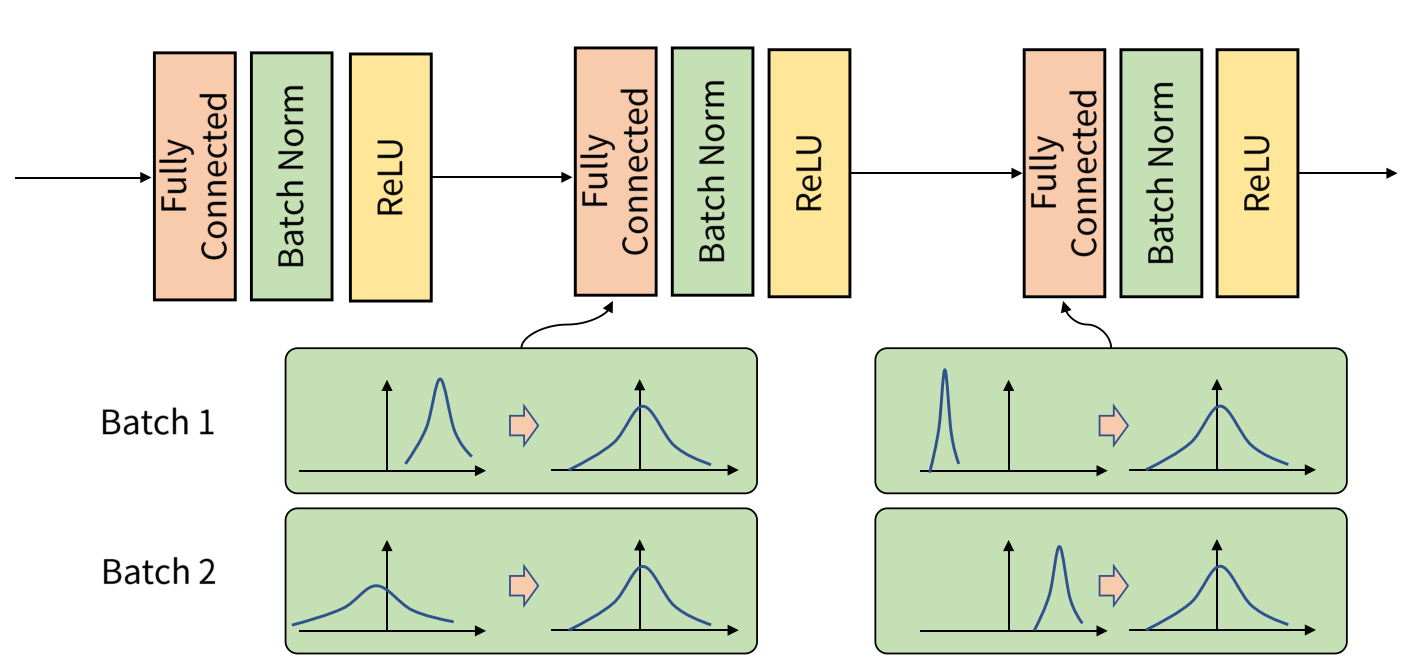
>
>또한, 여기서 model.train(), model.eval()의 역할이 나오는데,
train 모드일때는 $\mathbb{E}(x)$로 mini-batch의 평균을 사용하고, eval 모드일 때는 train 모드일 때 계산한 전체 데이터셋의 $\mathbb{E}(x)$를 사용하게 된다.
>
>그 이유는 eval 모드일 때는 mini-batch의 구성에 따라 결과가 달라지지 않아야 일관된 evaluation 결과가 나오기 때문이다.

In [ ]:
class MyModel(nn.Module):
    def __init__(self,
                 input_dim=784,
                 hidden_dim=(32, 32),
                 output_dim=10):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim[0])
        self.bn1 = nn.BatchNorm1d(hidden_dim[0]) # Batch Normalization 선언
        self.activation1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim[0], hidden_dim[1])
        self.bn2 = nn.BatchNorm1d(hidden_dim[1]) # Batch Normalization 선언
        self.activation2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim[1], output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x) # Batch Normalization
        x = self.activation1(x)
        x = self.fc2(x)
        x = self.bn2(x) # Batch Normalization
        x = self.activation2(x)
        x = self.fc3(x)
        return x
# learning rate scheduler
# bn

Epoch:  1| Step   500	| Loss: 0.344
Epoch:  2| Step  1000	| Loss: 0.176
Epoch:  2| Step  1500	| Loss: 0.182
Epoch:  3| Step  2000	| Loss: 0.152
Epoch:  3| Step  2500	| Loss: 0.158
Epoch:  4| Step  3000	| Loss: 0.139
Epoch:  4| Step  3500	| Loss: 0.144
Epoch:  5| Step  4000	| Loss: 0.120
Epoch:  5| Step  4500	| Loss: 0.134
Epoch:  6| Step  5000	| Loss: 0.124
Epoch:  6| Step  5500	| Loss: 0.126
Epoch:  7| Step  6000	| Loss: 0.120
Epoch:  7| Step  6500	| Loss: 0.124
Epoch:  8| Step  7000	| Loss: 0.108
Epoch:  9| Step  7500	| Loss: 0.115
Epoch:  9| Step  8000	| Loss: 0.105
Epoch: 10| Step  8500	| Loss: 0.117
Epoch: 10| Step  9000	| Loss: 0.105
test_acc: 0.968


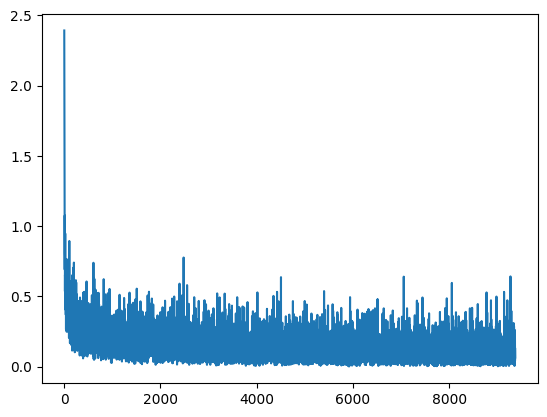

In [ ]:
model = MyModel()
model.to('cuda')

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.05)

model = train_model(model, criterion, optimizer, epoch=10)

test_model(model)

#6. Regularization

>딥러닝 모델의 크기에 비해 데이터가 부족할 경우 overfitting이 일어나기 쉽다.
>
>이를 해결하기 위해 딥러닝 모델을 학습할 때에는 각종 regularization 기법들을 도입하여 모델이 알맞은 복잡도를 갖도록 할 수 있다.
>
>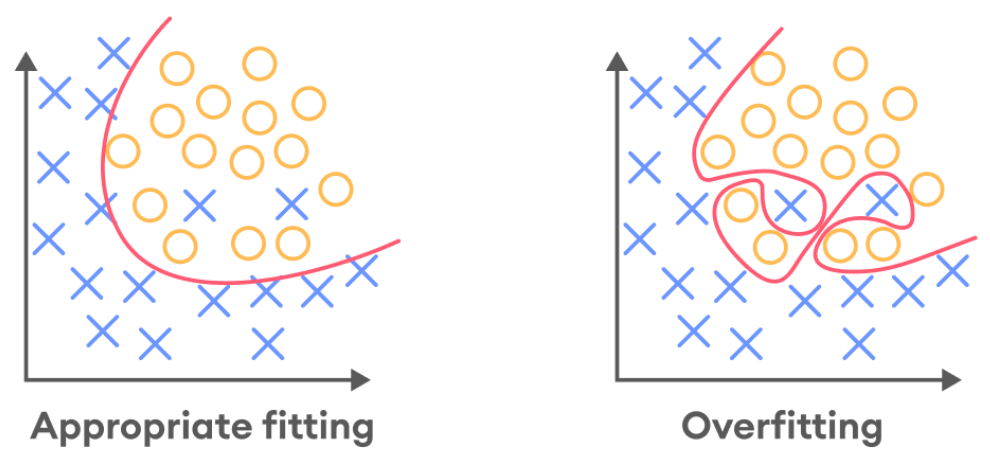

##6-1. L1, L2 Regularization


>L1, L2 regularization은 overfitting을 방지하는 대표적인 기법 중 하나이다.
>
>Regularization은 parameter들의 weight를 0에 가까워지도록 하면서 모델의 일부 parameter만을 이용해 예측을 하도록 유도하여 overffiting 현상을 방지할 수 있다.
>
>이번 예시에서는 l2 regularization을 구현한다.
>
>우선 모델을 데이터가 매우 적은 상황에서 학습시켜 overfitting이 일어나도록 한다.

In [ ]:
class MyModel(nn.Module):
    def __init__(self,
                 input_dim=784,
                 hidden_dim=(2048, 2048),
                 output_dim=10):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim[0])
        self.activation1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim[0], hidden_dim[1])
        self.activation2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim[1], output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation1(x)
        x = self.fc2(x)
        x = self.activation2(x)
        x = self.fc3(x)
        return x

In [ ]:
def train_model(model, criterion, optimizer, epoch, dataloader, batch_size):
    step = 0
    steps = []
    loss_list = []
    test_loss_list = []
    _test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True) # test loss 기록을 위해
    _test_iter = iter(_test_dataloader)

    model.train()
    for e in range(epoch):
        running_loss = 0.0
        for i, data in enumerate(dataloader):
            inputs, labels = data
            inputs = inputs.reshape(batch_size, -1)
            inputs = inputs.to('cuda')
            labels = labels.to('cuda')

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            step += 1
            steps.append(step)
            loss_list.append(loss.item())

            # test loss 계산
            with torch.no_grad():
                try:
                    test_inputs, labels = next(_test_iter)
                except:
                    _test_iter = iter(_test_dataloader)
                    test_inputs, labels = next(_test_iter)

                test_inputs = test_inputs.reshape(batch_size, -1)
                test_inputs = test_inputs.to('cuda')
                labels = labels.to('cuda')
                outputs = model(test_inputs)
                test_loss = criterion(outputs, labels)
                test_loss_list.append(test_loss.item())

            if step % 200 == 0 and i != 0:
                print(f'Epoch: {e+1:2d}| Step {step:5d}\t| Loss: {running_loss/(i):.3f}')

        running_loss = 0.0

    plt.plot(steps, loss_list, color='blue', label='train loss')
    plt.plot(steps, test_loss_list, color='red', label='test loss')
    plt.legend()
    return model

def test_model(model):
    model.eval()
    correct = 0
    for inputs, labels in test_dataloader:
        inputs = inputs.reshape(1, -1)
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')

        output = model(inputs)

        pred = output.max(1, keepdim=False)[1]
        correct += torch.eq(pred, labels).sum().item()

    test_acc = correct / len(test_dataloader.dataset)
    print('test_acc: %.3f' %(test_acc))

In [ ]:
list(range(0, 10, 2))

[0, 2, 4, 6, 8]

In [ ]:
len(list(range(0, len(train_dataset), 200)))

300

In [ ]:
batch_size = 10

subset = list(range(0, len(train_dataset), 300)) # 데이터를 1/3000로 축소
small_train_dataset = torch.utils.data.Subset(train_dataset, subset)

small_train_dataloader = torch.utils.data.DataLoader(small_train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

model = MyModel()
model.to('cuda') # GPU 사용을 위한 코드

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

model = train_model(model, criterion, optimizer, 200, small_train_dataloader, batch_size)

test_model(model)

>Training loss가 0에 수렴하지만 test loss는 수렴하지 않고, test accuracy는 50% 정도인 것을 미루어 보았을 때 overfitting이 일어났다고 판단할 수 있다.

>이제 기존의 loss function에 L2 regularization을 추가해보자.

In [ ]:
def train_model(model, criterion, optimizer, epoch, dataloader, batch_size):
    step = 0
    steps = []
    loss_list = []
    model.train()

    test_loss_list = []
    _test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True) # test loss 기록을 위해
    _test_iter = iter(_test_dataloader)
    for e in range(epoch):
        running_loss = 0.0
        for i, data in enumerate(dataloader):
            inputs, labels = data
            inputs = inputs.reshape(batch_size, -1)
            inputs = inputs.to('cuda')
            labels = labels.to('cuda')

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters()) # regularization term
            loss += 0.0005 * l2_norm
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            step += 1
            steps.append(step)
            loss_list.append(loss.item())

            # test loss 계산
            with torch.no_grad():
                try:
                    test_inputs, labels = next(_test_iter)
                except:
                    _test_iter = iter(_test_dataloader)
                    test_inputs, labels = next(_test_iter)

                test_inputs = test_inputs.reshape(batch_size, -1)
                test_inputs = test_inputs.to('cuda')
                labels = labels.to('cuda')
                outputs = model(test_inputs)
                test_loss = criterion(outputs, labels)
                test_loss_list.append(test_loss.item())

            if step % 200 == 0 and i != 0:
                print(f'Epoch: {e+1:2d}| Step {step:5d}\t| Loss: {running_loss/(i):.3f}')

        running_loss = 0.0

    plt.plot(steps, loss_list, color='blue', label='train loss')
    plt.plot(steps, test_loss_list, color='red', label='test loss')
    return model

In [ ]:
model = MyModel()
model.to('cuda')

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

optim.SGD(model.parameters(), lr=0.01, weight_decay=0.0001)

model = train_model(model, criterion, optimizer, 200, small_train_dataloader, batch_size)

test_model(model)

>L2 regularization을 사용할 경우 data가 적고, parameter가 많은 over-parametrized 상황에서 성능이 올라가는 것을 확인할 수 있다.

##6-2. Dropout

>Dropout은 overfitting을 방지하는 또 다른 방법으로, 학습할 때 랜덤하게 일부 parameter를 사용하지 않고 학습하는 방법이다.
>
>이로써 여러개의 작은 모델을 학습하는 효과를 얻게된다.
>
>추론 할 때에는 모든 파라메터를 모두 사용한다.
>
>최근에 공개되는 모델들에도 대부분 사용되는 layer이다.
>
>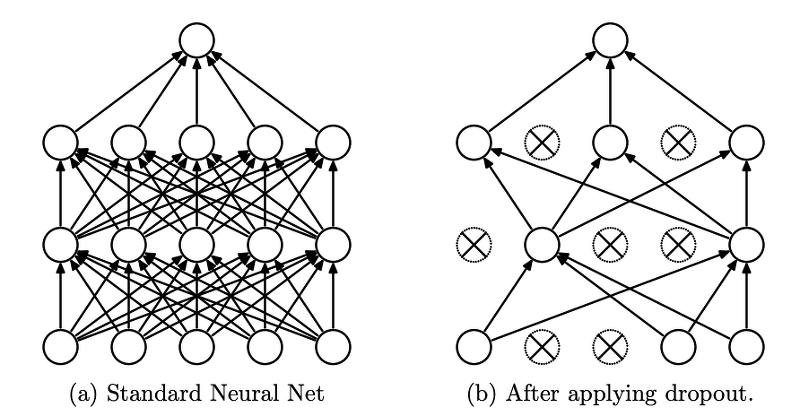

In [ ]:
class MyModel(nn.Module):
    def __init__(self,
                 input_dim=784,
                 hidden_dim=(2048, 2048),
                 output_dim=10):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim[0])
        self.activation1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.8) # Dropout 추가
        self.fc2 = nn.Linear(hidden_dim[0], hidden_dim[1])
        self.activation2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.8) # Dropout 추가
        self.fc3 = nn.Linear(hidden_dim[1], output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.activation2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [ ]:
def train_model(model, criterion, optimizer, epoch, dataloader, batch_size):
    step = 0
    steps = []
    loss_list = []
    model.train()
    for e in range(epoch):
        running_loss = 0.0
        for i, data in enumerate(dataloader):
            inputs, labels = data
            inputs = inputs.reshape(batch_size, -1)
            inputs = inputs.to('cuda')
            labels = labels.to('cuda')

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            step += 1
            steps.append(step)
            loss_list.append(loss.item())
            if step % 200 == 0 and i != 0:
                print(f'Epoch: {e+1:2d}| Step {step:5d}\t| Loss: {running_loss/(i):.3f}')

        running_loss = 0.0

    plt.plot(steps, loss_list)
    return model

def test_model(model):
    model.eval()
    correct = 0
    for inputs, labels in test_dataloader:
        inputs = inputs.reshape(1, -1)
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')

        output = model(inputs)

        pred = output.max(1, keepdim=False)[1]
        correct += torch.eq(pred, labels).sum().item()

    test_acc = correct / len(test_dataloader.dataset)
    print('test_acc: %.3f' %(test_acc))

In [ ]:
model = MyModel()
model.to('cuda') # GPU 사용을 위한 코드

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Train
model = train_model(model, criterion, optimizer, 200, small_train_dataloader, batch_size)

test_model(model)

##6-3. Data Augmentation

>모델 구조나 학습 방식에 제한을 두어 overfitting을 방지할 수 있지만, 학습 데이터의 개수를 늘리는 것도 overfitting 방지와 성능 향상에 큰 도움이 될 수 있다.
>
>주어진 학습 데이터를 변형하여 학습 데이터를 늘리는 것을 data augmentation이라고 한다.
>
>
>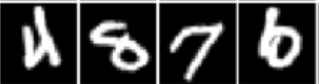

In [ ]:
transforms = torchvision.transforms.Compose([
        # torchvision.transforms.RandomRotation(degrees=30),
        torchvision.transforms.AugMix(),
        torchvision.transforms.ToTensor()
    ]) # Random rotation 추가

train_dataset_aug = torchvision.datasets.MNIST(root="./", train=True, download=True, transform=transforms)

subset = list(range(0, len(train_dataset_aug), 3000))
small_train_dataset_aug = torch.utils.data.Subset(train_dataset_aug, subset)

small_train_dataloader_aug = torch.utils.data.DataLoader(small_train_dataset_aug, batch_size=batch_size, shuffle=True, drop_last=True)

In [ ]:
class MyModel(nn.Module):
    def __init__(self,
                 input_dim=784,
                 hidden_dim=(2048, 2048),
                 output_dim=10):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim[0])
        self.activation1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim[0], hidden_dim[1])
        self.activation2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim[1], output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation1(x)
        x = self.fc2(x)
        x = self.activation2(x)
        x = self.fc3(x)
        return x

In [ ]:
model = MyModel()
model.to('cuda') # GPU 사용을 위한 코드

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Train
model = train_model(model, criterion, optimizer, 200, small_train_dataloader_aug, batch_size)

test_model(model)

>Data augmentation을 통해 데이터가 매우 적은 상황에서도 성능이 크게 향상된 것을 확인할 수 있다.

>Data augmentation은 데이터셋에 맞게 적절히 고르는 것이 중요하다.
>
>많이 사용하는 data augmentation 기법으로 radom shift, radom crop, random flip 등이 있다.
>
>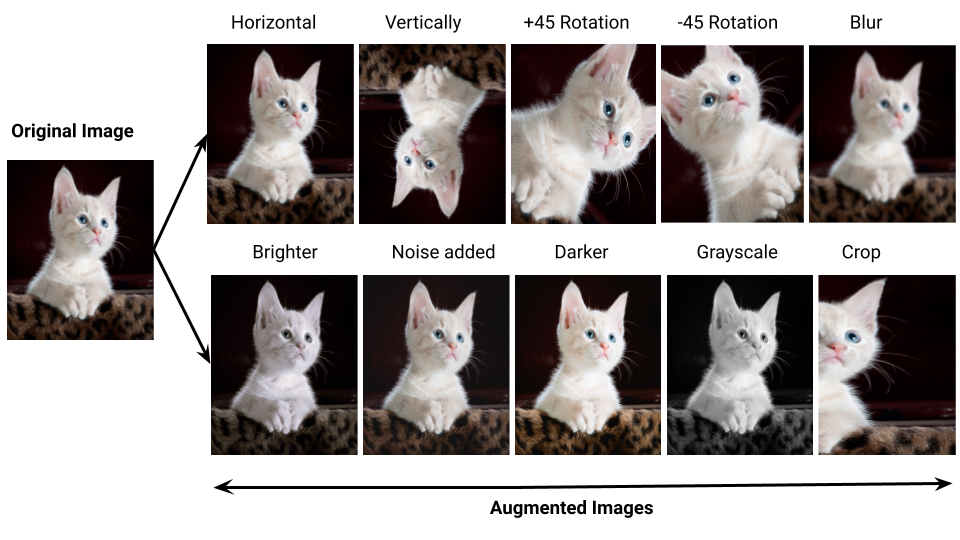
>
>https://pytorch.org/vision/stable/transforms.html 에서 다른 augmentation 기법도 확인할 수 있다.

#7. Hyperparameters

>딥러닝 학습 과정에서 학습이 불가능한 변수들이 있다.
>
>예를 들어 learning rate, batch size, training epoch 등은 학습을 통해 얻어지지 않고, 모델을 개발하는 개발자의 선택에 의해 결정된다.
>
>이러한 변수들을 hyperparameter라고 부르는데, 적절한 hyperparameter를 고르는 것은 모델 학습에서 매우 중요하다.
>

>CIFAR10 데이터셋은 60,000개의 32x32 "color" 이미지 데이터셋이다.
>
>총 10개의 class로 구성되어 있으며, 50,000개의 학습 데이터와 10,000개의 테스트 데이터로 구성되어 있다.
>
>CIFAR10은 MNIST보다 복잡도가 높은 데이터셋으로, 모델의 성능을 높이기 위해서 hyperparameter 등의 변수들을 좀 더 정교하게 조정해야 한다.
>
>
>Hyperparameter를 바꿔가며 CIFAR10 데이터셋을 잘 분류할 수 있는 모델을 만들어보자.


>
>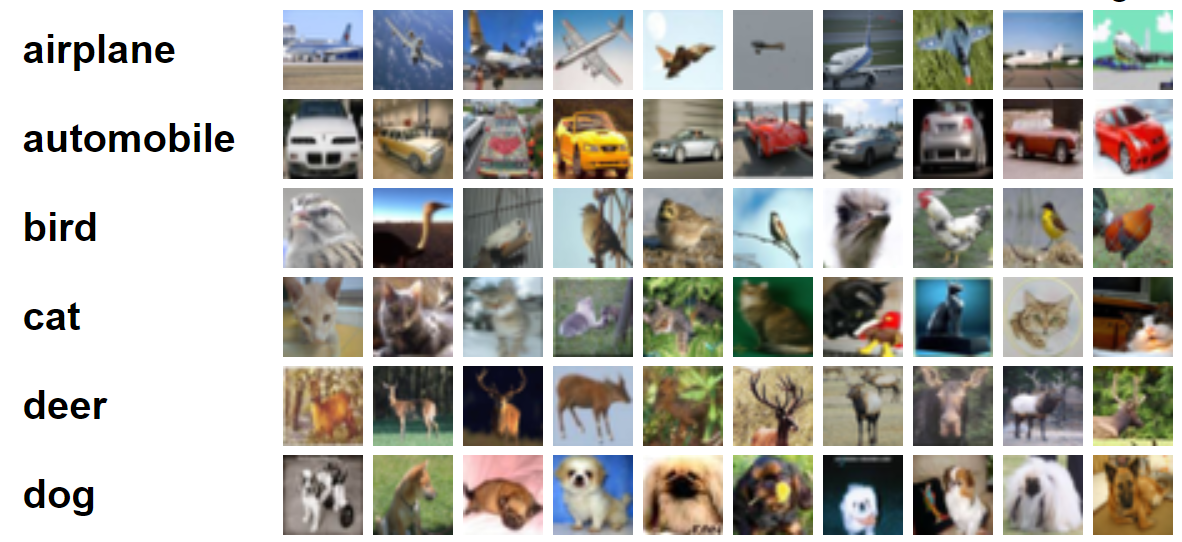

In [ ]:
transforms = torchvision.transforms.ToTensor()
train_dataset = torchvision.datasets.CIFAR10(root="./", train=True, download=True, transform=transforms)
test_dataset = torchvision.datasets.CIFAR10(root="./", train=False, download=True, transform=transforms)

In [ ]:
batch_size = 64

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
class MyModel(nn.Module):
    def __init__(self,
                 input_dim=1024*3, # 3 x 32 x 32
                 hidden_dim=(2048, 2048),
                 output_dim=10):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim[0])
        self.activation1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim[0], hidden_dim[1])
        self.activation2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim[1], output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation1(x)
        x = self.fc2(x)
        x = self.activation2(x)
        x = self.fc3(x)
        return x

##7-1. Learning rate

> Learning rate은 gradient descent 과정에서 step size 결정하는 hyperparameter이다.
>
> 큰 learning rate은 학습을 불안정하게 한다.
>
> 반대로 너무 작은 learning rate을 사용하면 학습이 매우 오래걸리게 된다.
>
> 따라서 딥러닝 모델을 학습할 때 알맞은 learning rate을 고르는 것이 매우 중요하다.
>
>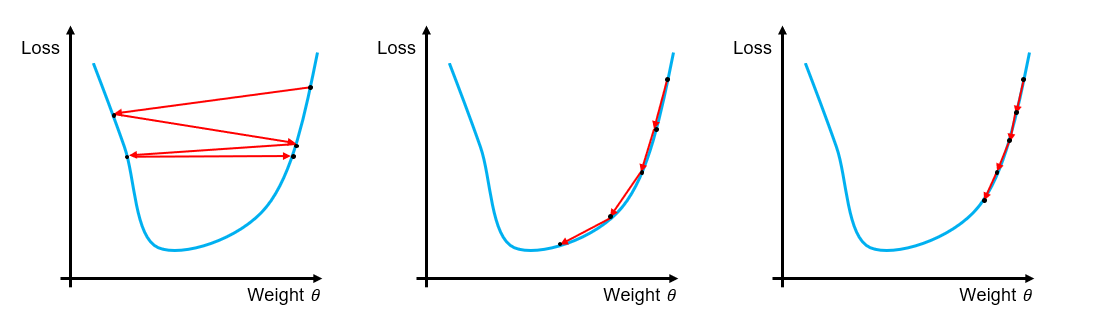

In [ ]:
def train_model(model, criterion, optimizer, epoch):
    step = 0
    steps = []
    loss_list = []
    model.train()
    for e in range(epoch):
        running_loss = 0.0
        for i, data in enumerate(train_dataloader):
            inputs, labels = data
            inputs = inputs.reshape(batch_size, -1)
            inputs = inputs.to('cuda')
            labels = labels.to('cuda')

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            step += 1
            steps.append(step)
            loss_list.append(loss.item())

            if step % 500 == 0 and i != 0:
                print(f'Epoch: {e+1:2d}| Step {step:5d}\t| Loss: {running_loss/(i):.3f}')

        running_loss = 0.0

    plt.plot(steps, loss_list)
    return model

def test_model(model):
    model.eval()
    correct = 0
    for inputs, labels in test_dataloader:
        inputs = inputs.reshape(1, -1)
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')

        output = model(inputs)

        pred = output.max(1, keepdim=False)[1]
        correct += torch.eq(pred, labels).sum().item()

    test_acc = correct / len(test_dataloader.dataset)
    print('test_acc: %.3f' %(test_acc))

>모델에 따라 차이가 있지만, 일반적으로 1e-2 (0.01) ~ 1e-4 (0.0001) 정도의 learning rate이 좋은 시작점이 된다.
>
>가장 먼저, learning rate을 크게 설정한 후 학습을 해보자.

In [ ]:
model = MyModel()
model.to('cuda')

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1.) # 너무 큰 learning rate

model = train_model(model, criterion, optimizer, epoch=10)

test_model(model)

>Learning rate이 큰 경우 loss가 일정하게 줄어들지 않고, 또 충분하게 작은 값으로 수렴하지 않는다.

>Learning rate을 매우 작게 설정한 후 학습을 해보자.

In [ ]:
model = MyModel()
model.to('cuda')

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00000001) # 너무 작은 learning rate

model = train_model(model, criterion, optimizer, epoch=10)

test_model(model)

>Learning rate이 매우 작을 경우 loss가 감소하긴 하지만 학습이 매우 천천히 일어나는 것을 확인할 수 있다.

>이전에 사용한 learning rate들의 중간값을 사용해 학습해보자.

In [ ]:
model = MyModel()
model.to('cuda') # GPU 사용을 위한 코드

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # 알맞은 learning rate

model = train_model(model, criterion, optimizer, epoch=10)

test_model(model)

학습이 상대적으로 원활하게 이루어지는 것을 확인할 수 있다.

##7-2. Batch size

> Batch size는 한번의 step에 사용되는 mini batch의 데이터 개수를 뜻한다.
>
> Batch size가 크면 클 수록 일반적으로는 높은 성능을 낼 수 있다.
>
> 특히 batch normalization을 적용할 경우 작은 batch size는 성능에 악영향을 끼칠 수 있다.
>
> 하지만 batch size에 비례해서 GPU memory 가 필요하기 때문에 무작정 큰 batch size로 학습할 수는 없다.
>
> Batch size와 학습 속도, 모델 성능의 연관성을 알아보도록 해보자.

>우선 batch size를 16으로 줄여서 학습을 해보자.

In [ ]:
import time

batch_size = 16 # batch size 16

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

model = MyModel()
model.to('cuda')

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

start_time = time.time()
model = train_model(model, criterion, optimizer, epoch=10)
end_time = time.time()

print('total time elapsed: ', end_time-start_time)

test_model(model)

> Batch size를 64로 키워보자.

In [ ]:
batch_size = 64 # batch size 64

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

model = MyModel()
model.to('cuda')

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

start_time = time.time()
model = train_model(model, criterion, optimizer, epoch=10)
end_time = time.time()

print('total time elapsed: ', end_time-start_time)

test_model(model)

> Batch size를 128로 키워보자.

In [ ]:
batch_size = 128 # batch size 128

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

model = MyModel()
model.to('cuda')

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

start_time = time.time()
model = train_model(model, criterion, optimizer, epoch=10)
end_time = time.time()

print('total time elapsed: ', end_time-start_time)

test_model(model)

>일반적으로 batch size가 크면 학습이 안정적으로 이루어지고 모델의 성능이 높아진다.
>
>또한, GPU의 병렬 연산 능력으로 인해, 같은 epoch을 학습할 때 소요되는 시간이 줄어든다.

##7-3. Training epoch

> training epoch 역시 중요한 hyperparameter 중 하나이다.
>
> 학습 과정을 관찰하면서 최적의 학습 epoch을 찾아보자.

In [ ]:
def train_model(model, criterion, optimizer, epoch):
    step = 0
    steps = []
    loss_list = []
    model.train()
    for e in range(epoch):
        running_loss = 0.0
        for i, data in enumerate(train_dataloader):
            inputs, labels = data
            inputs = inputs.reshape(batch_size, -1)
            inputs = inputs.to('cuda')
            labels = labels.to('cuda')

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            step += 1
            steps.append(step)
            loss_list.append(loss.item())

            if step % 500 == 0 and i != 0:
                print(f'Epoch: {e+1:2d}| Step {step:5d}\t| Loss: {running_loss/(i):.3f}')

        # 학습 중간에 test data에 대한 evaluation 진행
        if e%5 == 0:
            print('current epoch: ', e)
            test_model(model)

        running_loss = 0.0

    plt.plot(steps, loss_list)
    return model

In [ ]:
batch_size = 128
epoch = 30

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

model = MyModel()
model.to('cuda')

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(model, criterion, optimizer, epoch)

print('final result')
test_model(model)

>Epoch 15의 test accuracy가 가장 좋은 성능을 보인다.
>
>따라서 가장 좋은 모델을 사용하고자 한다면 epoch 15의 model state_dict를 따로 저장해두어 사용하면 된다.

##7-4. Hyperparameter search

> 학습하고자 하는 모델에 따라 최적의 hyperparameter는 바뀌기 마련이다.
>
> Hyperparamter을 찾는 방법으로, grid search를 소개하고자 한다.
>
> Grid search란, 각 hyperparameter에 대한 몇 가지 후보군을 정해놓고 각 조합 별로 학습을 돌려보는 탐색 방법이다.
>


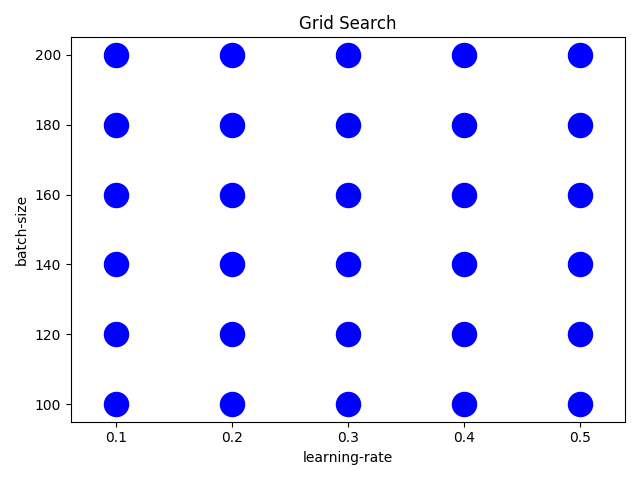

>Learning rate 후보군을 0.01, 0.001, 0.0001 로, batch size 후보군을 32, 64, 128 로 둔 뒤, 총 3 x 3 = 9개 조합에 grid search를 해보고, 최적의 hyperparameter를 찾아보자.

In [ ]:
def train_model(model, criterion, optimizer, epoch):
    step = 0
    steps = []
    loss_list = []
    model.train()
    for e in range(epoch):
        running_loss = 0.0
        for i, data in enumerate(train_dataloader):
            inputs, labels = data
            inputs = inputs.reshape(batch_size, -1)
            inputs = inputs.to('cuda')
            labels = labels.to('cuda')

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            step += 1
            steps.append(step)
            loss_list.append(loss.item())

        running_loss = 0.0

    return model

def test_model(model):
    model.eval()
    correct = 0
    for inputs, labels in test_dataloader:
        inputs = inputs.reshape(1, -1)
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')

        output = model(inputs)

        pred = output.max(1, keepdim=False)[1]
        correct += torch.eq(pred, labels).sum().item()

    test_acc = correct / len(test_dataloader.dataset)
    print('test_acc: %.3f' %(test_acc))

In [ ]:
batch_size_list = [32,64,128] # batch size 후보군
lr_list = [0.01, 0.001, 0.0001] # learning rate 후보군
epoch = 10

# grid search
for batch_size in batch_size_list:
    for lr in lr_list:
        train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
        test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

        model = MyModel()
        model.to('cuda')

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        model = train_model(model, criterion, optimizer, epoch)

        print(f'batch size: {batch_size}  learning rate: {lr}')
        test_model(model)
        print('=====')

> Grid search를 통해 결과적으로로 batch size = 32, learning rate = 0.0001을 사용하는 것이 최적의 조합임을 찾아낼 수 있다.